## Template - do not modify, duplicate

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Spectral'

In [2]:
def sigmoid(z) :
    """
    Returns the sigmoid function of the given input
    """
    return 1 /(1 + np.exp(-z))

def sigmoid_prime(z) :
    """
    Returns the derivative of the sigmoid function of the given input
    """
    return sigmoid(z)*(1-sigmoid(z))

def fp(x, eps):
    """
    Returns the value the SReLU takes in the interval -eps to eps
    
    The polynomial satifies the following conditions:
    fp(eps) = eps
    fp'(eps) = 1
    fp(-eps) = 0
    fp'(-eps) = 0
    
    """
    a_0 = eps/4
    a_1 = 0.5
    a_2 = 1/(4*eps)
    a_3 = 0
    
    return  a_0 + a_1*x + a_2*x**2 + a_3*x**3 

def SReLU(x, eps):
    """
    Returns a smoothed ReLU function with parameter epsilon
    """
    return fp(x, eps)*(np.abs(x) < eps) + x*(x >= eps)


def fp_prime(x, eps):
    """
    Returns derivative of the fp(x) with respect to x
    """
    a_0 = eps/4
    a_1 = 0.5
    a_2 = 1/(4*eps)
    a_3 = 0
    
    return  a_1 + 2*a_2*x + 3*a_3*x**2 

def SReLU_prime(x,eps):
    """
    Returns the derivative of the smoothed ReLU function
    """
    return fp_prime(x, eps)*(np.abs(x) < eps) + 1*(x >= eps)

def relu(z): 
    """
    Returns the rectified linear unit applied to the given input 
    """
    return np.maximum(0,z)

def relu_prime(z) :
    """
    Returns the derivative of rectified linear unit applied to the given input 
    """
    return 1*(z>=0)

def SReLU_prime_wrt_eps(x,eps):
    """
    Returns the derivative of the SReLU function
    with respect to epsilon given the input and parameter eps
    """
    return (1/4-(x**2)/(4*eps**2))*(np.abs(x) < eps)

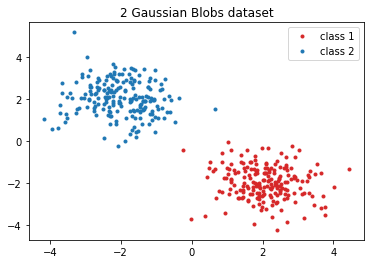

In [3]:
from sklearn.datasets import make_blobs

N = 400 # no. points

X, y = make_blobs(n_samples = N, centers = [(2,-2),(-2,2)], 
                  n_features = 2, cluster_std = 0.8, random_state = 1)
labels_orig = y
y = np.mod(labels_orig, 2)
y = y.reshape(y.shape[0],1)

plt.title('2 Gaussian Blobs dataset')
plt.plot(X[y[:,0]==0,0], X[y[:,0]==0,1], color='tab:red', marker='.', linestyle='None',label='class 1')
plt.plot(X[y[:,0]==1,0], X[y[:,0]==1,1], color='tab:blue', marker='.', linestyle='None', label='class 2')
plt.legend()
plt.show()

In [4]:
def plotboundary_accuracy(X, y, W1, b1, W2, b2,eps):
    """
    Returns the accuracy for the given parameters and plots the decision boundary of the data
    """
    predicted_class = sigmoid(np.dot(SReLU(np.dot(X, W1) + b1,eps), W2) + b2)
    print('Accuracy: %.2f %%' % (100*np.mean((predicted_class >0.5) == y)))

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
    Z_axis = sigmoid(np.dot(SReLU(np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1,eps), W2) + b2)
    Z_axis = (Z_axis > 0.5)
    Z_axis = Z_axis.reshape(xx.shape)
    plt.contourf(xx, yy, Z_axis, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y[:,0], s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [5]:
def initialize_parameters(n_x,n_y,n_h):
    """
     Initialization of the weights and biases for the neural network
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
    """
    
    np.random.seed(1)                   # Random seed for weights
    W1 = 1 * np.random.randn(n_x,n_h) # [n_x, n_h ]
    b1 = np.zeros((1,n_h))              # [1, n_h ]
    W2 = 1 * np.random.randn(n_h,n_y) # [n_h, n_y ]
    b2 = np.zeros((1,n_y))              # [1, n_y ]
    np.random.seed(None)              # Random seed for weighs
    
    return W1, b1, W2, b2   # Return initalise weights and biases

In [6]:
def forward_prop(X, W1, b1, W2, b2,eps):
    """
     Return the parameters after one foward pass 
     N: Number of points per class
     X: dimension [2N, n_x]
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
     
    """
    Z1 = np.dot(X, W1) + b1   # [2N, n_h]
    A1 = SReLU(Z1,eps) # [2N, n_h]
    Z2 = np.dot(A1, W2) + b2  # [2N, n_y]
    A2 = sigmoid(Z2)          # [2N, n_y]
    
    return Z1, A1, Z2, A2

In [7]:
def cost(Y, A2):
    """
    Returns the L2 error between the predicted values 
    by the network A2 and the actual values of the data Y
    """
    m = Y.shape[0]
    return np.sum(np.square(Y-A2))/m


In [8]:
def back_prop(X,y, Z1, A1, Z2, A2, reg, eps):
    """
     Return the gradient of parameters with respect to the loss after one foward pass 
     reg: regularisation parameter
     eps: smoothed ReLU parameter epsilon
     N: Number of points per class
     X: dimension [2N, n_x]
     n_x: number of inputs nodes
     n_y: number of output nodes
     n_h: number of hidden nodes
     """
    
    m = X.shape[0]                # Number of data points in total, 2N
    
    dZ2 = -2*(y-A2)/m     # Derivative of cross-entropy loss is (A2-y), [m,1]
    dZ2 = dZ2*sigmoid_prime(Z2)   # Derivative with respect to Z2, [m,1]

    dW2 = np.dot(A1.T, dZ2)                     # Derivative with respect to W2, [n_h, n_y ]
    db2 = np.sum(dZ2, axis=0, keepdims=True)    # Derivative with respect to b2, [1, n_y ]

    dA1 = np.dot(dZ2, W2.T)                             # Derivative with respect to A1, [m, n_h]
    dZ1 = np.multiply(dA1, SReLU_prime(Z1,eps))  # Derivative with respect to Z1, [m, n_h]
    
    # Derivative with respect to epsilon, [1, 1]
    depsilon = np.sum(np.multiply(dA1,SReLU_prime_wrt_eps(Z1,eps))) # SUM over two axis 
    
    dW1 = np.dot(X.T, dZ1)                   # Derivative with respect to W1, [n_x, n_h]
    db1 = np.sum(dZ1, axis=0, keepdims=True) # Derivative with respect to b1, [1, n_h]

    dW2 = dW2 + reg * W2 # regularisation of weight W2
    dW1 = dW1 + reg * W1 # regularisation of weight W1
    #depsilon = depsilon + reg * eps # regularisation of weight W1

    return dW1, db1, dW2, db2, depsilon

In [9]:
def update_parameters(W1, b1, W2, b2, epsilon_vector, dW1, db1, dW2, db2, depsilon_vector, learning_rate):
    """
    Returns the updated values of the parameters 
    after the given interation 
    """
    
    W1 = W1 - dW1 * learning_rate
    b1 = b1 - db1 * learning_rate
    W2 = W2 - dW2 * learning_rate
    b2 = b2 - db2 * learning_rate
    epsilon_vector = epsilon_vector - depsilon_vector*0.1
    
    return W1, b1, W2, b2, epsilon_vector

In [10]:
# Setting parameters
epochs = 10000
learning_rate = 0.2
runs = 1
reg = 0

In [11]:
n_h = 1
n_x = 2
n_y = 1

epsilon_iter = np.zeros(epochs+1)
Z1_iter = np.zeros((epochs, 400, n_h))
    
W1, b1, W2, b2 = initialize_parameters(2,1,n_h)
epsilon_vector = 0.5
epsilon_iter[0]= epsilon_vector
        
for i in range(epochs):
    
    Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2,epsilon_vector)
            
    dW1, db1, dW2, db2,depsilon = back_prop(X,y, Z1, A1, Z2, A2, reg, epsilon_vector)
        
    W1, b1, W2, b2, epsilon_vector= update_parameters(W1, b1, W2, b2, epsilon_vector, 
                                                      dW1, db1, dW2, db2, depsilon, learning_rate)   
    epsilon_iter[i+1] = epsilon_vector
    Z1_iter[i,:] = Z1
        

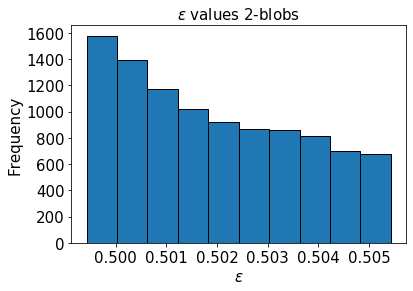

In [12]:
plt.hist(epsilon_iter, histtype='bar', ec='black')
plt.title(r'$\varepsilon$ values 2-blobs',fontsize=15)
plt.xlabel(r'$\varepsilon$', fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize = 15) 
plt.yticks(fontsize = 15) 

plt.show()